In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [2]:
import jianbing
from jianbing import visual
from jianbing import catalog

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR

## Simulated Lensing Profiles

- Show how does the $\Delta\Sigma$ profiles vary with scatter of halo mass in the bin.
- Also highlight a few halo mass distributions.

In [6]:
# DeltaSigma profiles from simulation
sim_dsig = Table.read(os.path.join(sim_dir, 'sim_merge_all_dsig.fits'))

# Halo mass distribution within different bins for different mock halo mass - observable relations
sim_mhalo = Table.read(os.path.join(sim_dir, 'sim_merge_mhalo_hist.fits'))

NameError: name 'sim_dsig' is not defined

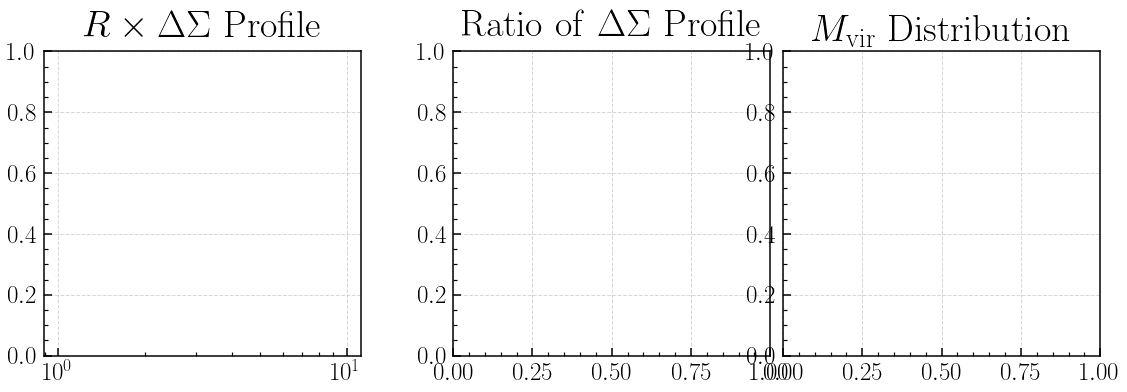

In [5]:
fig = plt.figure(figsize=(16, 10))

n_col, n_bins = 3, 2
left, right = 0.07, 0.98
bottom, top = 0.09, 0.935
x_space = 0.08
x_size = (right - left - x_space * 1.05) / n_col
y_size = (top - bottom) / n_bins

for ii, bin_id in enumerate([1, 4]):
    # Setup the three columns
    ax1 = fig.add_axes([left, top - y_size * (ii + 1), x_size, y_size])
    ax2 = fig.add_axes([left + x_space + x_size, top - y_size * (ii + 1), x_size, y_size])
    ax3 = fig.add_axes([left + x_space + x_size * 2.04, top - y_size * (ii + 1), x_size, y_size])
    
    # Subplot title
    if bin_id == 1:
        ax1.set_title(r'$R \times \Delta\Sigma\ \rm Profile$', fontsize=38, pad=18)
        ax2.set_title(r'$\rm Ratio\ of\ \Delta\Sigma\ \rm Profile$', fontsize=38, pad=15)
        ax3.set_title(r'$M_{\rm vir}\ \rm Distribution$', fontsize=38)
    
    # Color map 
    cmap = cmap_list[bin_id - 1]
    
    # ----- Plot 1: R x DSigma plot ----- #
    ax1.set_xscale("log", nonpositive='clip')

    for mod in sim_dsig[sim_dsig['bin'] == (bin_id - 1)]:
        scatter = mod['scatter'] / np.max(sim_dsig['scatter'])
        ax1.plot(mod['r_mpc'], mod['r_mpc'] * mod['dsig'], c=cmap.mpl_colormap(scatter), 
                 alpha=0.7, linewidth=3.5, rasterized=True)
    ds_sig0 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & (sim_dsig['scatter'] <= 0.005)]
    ax1.set_ylim(5.5, np.max(ds_sig0['r_mpc'] * ds_sig0['dsig']) * 1.35)
    
    # Highlight sigma=0.4
    ds_sig4 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & 
                         (sim_dsig['scatter'] > 0.39) & (sim_dsig['scatter'] < 0.41)]
    ax1.plot(ds_sig4['r_mpc'][0], ds_sig4['r_mpc'][0] * ds_sig4['dsig'][0], c=cmap.mpl_colormap(0.2), 
             alpha=1.0, linewidth=4.0, linestyle='--', rasterized=True, zorder=1000)
    
    # Highlight sigma=0.6
    ds_sig6 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & 
                         (sim_dsig['scatter'] > 0.59) & (sim_dsig['scatter'] < 0.61)]
    ax1.plot(ds_sig6['r_mpc'][0], ds_sig6['r_mpc'][0] * ds_sig6['dsig'][0], c=cmap.mpl_colormap(0.1), 
             alpha=1.0, linewidth=4.0, linestyle='-.', rasterized=True, zorder=1000)
    
    # Color bar
    cax = fig.add_axes(
        [left + x_size / 2.2, top - y_size * ii - 0.05, x_size / 2, y_size / 14])
    norm = mpl.colors.Normalize(vmin=0.0, vmax=np.max(sim_dsig['scatter']))
    cbar = mpl.colorbar.ColorbarBase(
        cax, cmap=cmap.mpl_colormap, norm=norm, orientation='horizontal')
    cbar.set_label(r'$\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}}\ [\rm dex]$', fontsize=22)
    for tick in cax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    # Bin ID
    _ = ax1.text(0.08, 0.83, r'$\rm Bin\ {:1d}$'.format(bin_id), fontsize=35, 
                 transform=ax1.transAxes)
    
    if bin_id == 4:
        _ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
    else:
        ax1.set_xticklabels([])
    _ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=30)


    # ----- Plot 2: Ratio of DSigma plot ----- #
    ax2.set_xscale("log", nonpositive='clip')

    for mod in sim_dsig[sim_dsig['bin'] == (bin_id - 1)]:
        sig0 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & (sim_dsig['scatter'] < 0.01)][0]
        scatter = mod['scatter'] / np.max(sim_dsig['scatter'])
        ax2.plot(mod['r_mpc'], mod['dsig'] / sig0['dsig'], c=cmap.mpl_colormap(scatter), 
                 alpha=0.7, linewidth=3.5, rasterized=True)
    ax2.set_ylim(0.001, 1.09)
    
    # Highlight sigma=0.4
    ax2.plot(ds_sig4['r_mpc'][0], ds_sig4['dsig'][0] / sig0['dsig'], c=cmap.mpl_colormap(0.2), 
             alpha=1.0, linewidth=4.5, linestyle='--', rasterized=True, zorder=1000, 
             label=r'$\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}} = 0.4$')
    
    # Highlight sigma=0.6
    ds_sig6 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & 
                         (sim_dsig['scatter'] > 0.59) & (sim_dsig['scatter'] < 0.61)]
    ax2.plot(ds_sig6['r_mpc'][0], ds_sig6['dsig'][0] / sig0['dsig'], c=cmap.mpl_colormap(0.1), 
             alpha=1.0, linewidth=4.0, linestyle='-.', rasterized=True, zorder=1000,
             label=r'$\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}} = 0.6$')
    
    if bin_id == 4:
        ax2.legend(loc='lower right', fontsize=20)

    if bin_id == 4:
        _ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
    else:
        ax2.set_xticklabels([])
    _ = ax2.set_ylabel(r'$\Delta\Sigma/\Delta\Sigma_{\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}}=0}$', fontsize=30)

    # ----- Plot 3: Halo mass distribution plot ----- #
    # Histogram for sigma = 0.0
    
    if bin_id == 1:
        n_bins = 8
    elif bin_id == 2:
        n_bins = 4
    else:
        n_bins = 3
        
    ax3.axhline(0.0, linewidth=3.0, c='grey', alpha=0.7)
        
    # Histogram for "true" halo mass distribution
    mvir_true, hist_true, mvir_avg_true = catalog.rebin_mhalo_hist(
        sim_mhalo, bin_id - 1, 0.0, n_bin=n_bins)
    
    ax3.fill_between(mvir_true, hist_true / hist_true.sum() / 1.7, color=cmap.mpl_colormap(0.0), 
                     step="pre", alpha=0.8, label=r'$\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}}=0.0$', zorder=0)
    ax3.axvline(mvir_avg_true, color='k', alpha=0.7, linewidth=3.0, linestyle='-')
        
    # Histogram for sigma = 0.4
    mvir_1, hist_1, mvir_avg_1 = catalog.rebin_mhalo_hist(
        sim_mhalo, bin_id - 1, 0.4, n_bin=20)
                                             
    ax3.fill_between(mvir_1, hist_1 / hist_1.sum(), facecolor=cmap.mpl_colormap(0.0),
                     step="pre", alpha=0.3, label=r'$\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}}=0.4$', linestyle='-', 
                     edgecolor='w', zorder=1, linewidth=3)
    ax3.axvline(mvir_avg_1, color='grey', alpha=1.0, linewidth=4.0, linestyle='--')
    
    # Histogram for sigma = 0.6
    mvir_2, hist_2, mvir_avg_2 = catalog.rebin_mhalo_hist(
        sim_mhalo, bin_id - 1, 0.6, n_bin=20)
                                             
    ax3.step(mvir_2, hist_2 / hist_2.sum() / 1.5, linewidth=4.0, linestyle='--', 
             label=r'$\sigma_{\tiny{\mathcal{M}}|\tiny{\mathcal{O}}}=0.6$',
             color=cmap.mpl_colormap(0.0), alpha=0.9, zorder=2)
    ax3.axvline(mvir_avg_2, color='grey', alpha=1.0, linewidth=4.0, linestyle=':')
    
    ax3.set_xlim(12.2, 15.45)
    
    if bin_id == 1:
        handles, labels = ax3.get_legend_handles_labels()
        handles = [handles[1], handles[2], handles[0]]
        labels = [labels[1], labels[2], labels[0]]
        ax3.legend(handles, labels, loc='best', fontsize=20)

    ax3.set_yticklabels([])
    if bin_id == 4:
        _ = ax3.set_xlabel(r'$\log(M_{\rm vir}/M_{\odot})\ [\rm dex]$', fontsize=30)
    else:
        ax3.set_xticklabels([])

In [24]:

fig.savefig(os.path.join(fig_dir, 'fig_2.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_2.pdf'), dpi=120)

### Figure that shows all four bins

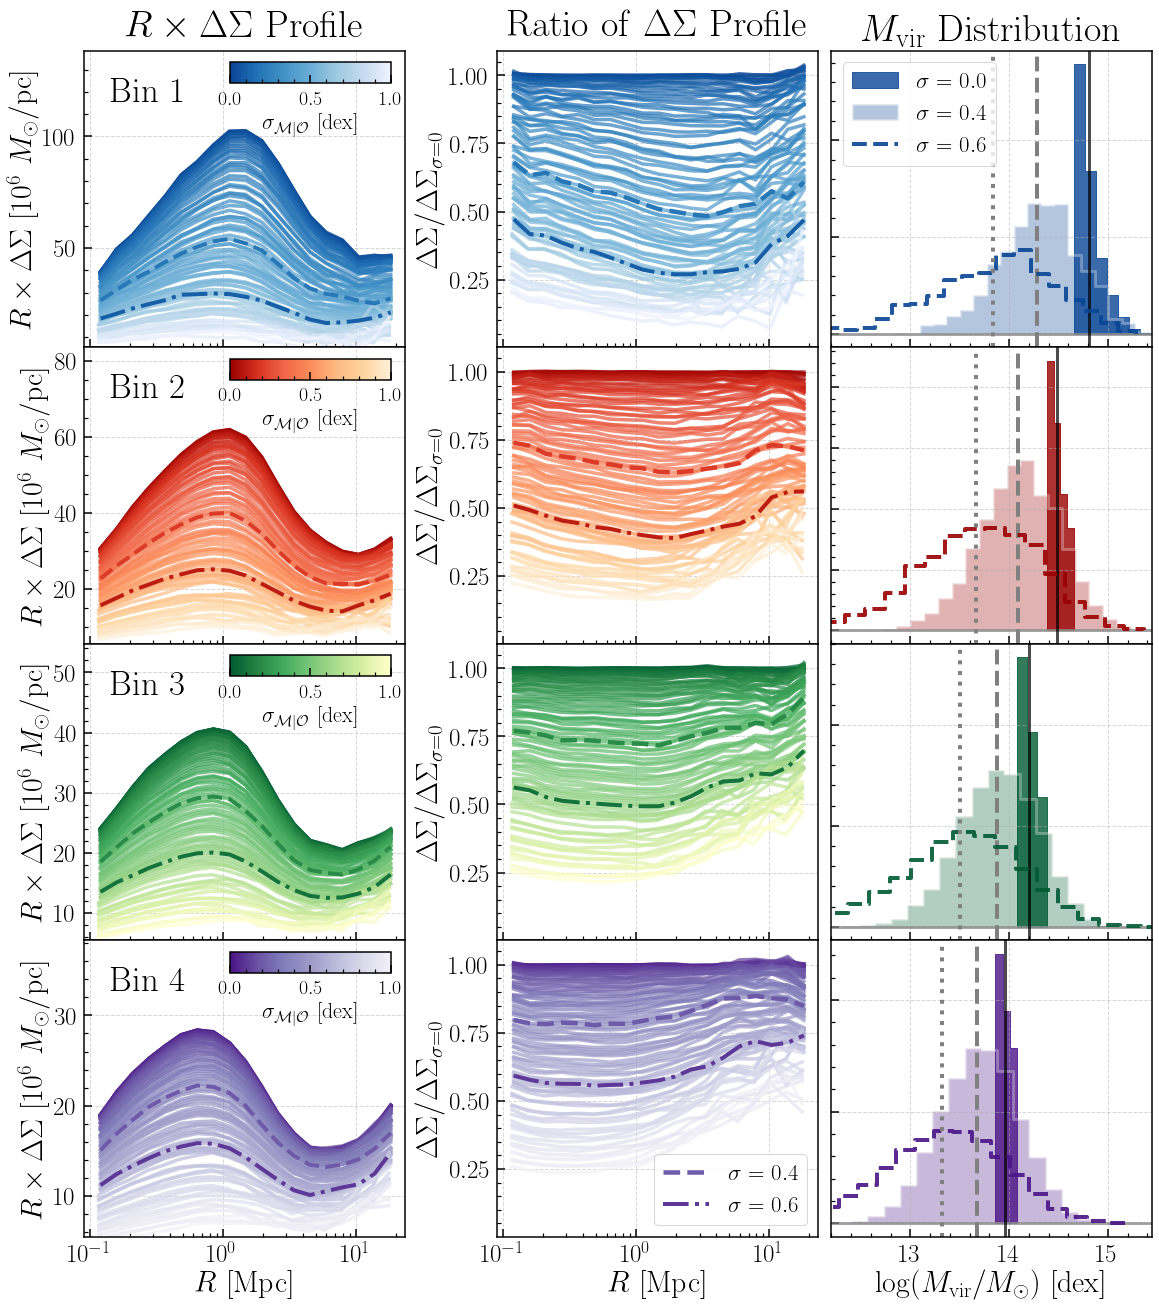

In [19]:
fig = plt.figure(figsize=(16, 18))

n_col, n_bins = 3, 4
left, right = 0.07, 0.99
bottom, top = 0.05, 0.965
x_space = 0.08
x_size = (right - left - x_space * 1.05) / n_col
y_size = (top - bottom) / n_bins

for bin_id in np.arange(4) + 1:
    # Setup the three columns
    ax1 = fig.add_axes([left, top - y_size * bin_id, x_size, y_size])
    ax2 = fig.add_axes([left + x_space + x_size, top - y_size * bin_id, x_size, y_size])
    ax3 = fig.add_axes([left + x_space + x_size * 2.04, top - y_size * bin_id, x_size, y_size])
    
    # Subplot title
    if bin_id == 1:
        ax1.set_title(r'$R \times \Delta\Sigma\ \rm Profile$', fontsize=38, pad=18)
        ax2.set_title(r'$\rm Ratio\ of\ \Delta\Sigma\ \rm Profile$', fontsize=38, pad=15)
        ax3.set_title(r'$M_{\rm vir}\ \rm Distribution$', fontsize=38)
    
    # Color map 
    cmap = cmap_list[bin_id - 1]
    
    # ----- Plot 1: R x DSigma plot ----- #
    ax1.set_xscale("log", nonpositive='clip')

    for mod in sim_dsig[sim_dsig['bin'] == (bin_id - 1)]:
        scatter = mod['scatter'] / np.max(sim_dsig['scatter'])
        ax1.plot(mod['r_mpc'], mod['r_mpc'] * mod['dsig'], c=cmap.mpl_colormap(scatter), 
                 alpha=0.7, linewidth=3.5, rasterized=True)
    ds_sig0 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & (sim_dsig['scatter'] <= 0.005)]
    ax1.set_ylim(5.5, np.max(ds_sig0['r_mpc'] * ds_sig0['dsig']) * 1.35)
    
    # Highlight sigma=0.4
    ds_sig4 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & 
                         (sim_dsig['scatter'] > 0.39) & (sim_dsig['scatter'] < 0.41)]
    ax1.plot(ds_sig4['r_mpc'][0], ds_sig4['r_mpc'][0] * ds_sig4['dsig'][0], c=cmap.mpl_colormap(0.2), 
             alpha=1.0, linewidth=4.0, linestyle='--', rasterized=True, zorder=1000)
    
    # Highlight sigma=0.6
    ds_sig6 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & 
                         (sim_dsig['scatter'] > 0.59) & (sim_dsig['scatter'] < 0.61)]
    ax1.plot(ds_sig6['r_mpc'][0], ds_sig6['r_mpc'][0] * ds_sig6['dsig'][0], c=cmap.mpl_colormap(0.1), 
             alpha=1.0, linewidth=4.0, linestyle='-.', rasterized=True, zorder=1000)
    
    # Color bar
    cax = fig.add_axes(
        [left + x_size / 2.2, top - y_size * (bin_id - 1) - 0.025, x_size / 2, y_size / 14])
    norm = mpl.colors.Normalize(vmin=0.0, vmax=np.max(sim_dsig['scatter']))
    cbar = mpl.colorbar.ColorbarBase(
        cax, cmap=cmap.mpl_colormap, norm=norm, orientation='horizontal')
    cbar.set_label(r'$\sigma_{\small{\mathcal{M}}|\small{\mathcal{O}}}\ [\rm dex]$', fontsize=22)
    for tick in cax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    # Bin ID
    _ = ax1.text(0.08, 0.83, r'$\rm Bin\ {:1d}$'.format(bin_id), fontsize=35, 
                 transform=ax1.transAxes)
    
    if bin_id == 4:
        _ = ax1.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
    else:
        ax1.set_xticklabels([])
    _ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=30)


    # ----- Plot 2: Ratio of DSigma plot ----- #
    ax2.set_xscale("log", nonpositive='clip')

    for mod in sim_dsig[sim_dsig['bin'] == (bin_id - 1)]:
        sig0 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & (sim_dsig['scatter'] < 0.01)][0]
        scatter = mod['scatter'] / np.max(sim_dsig['scatter'])
        ax2.plot(mod['r_mpc'], mod['dsig'] / sig0['dsig'], c=cmap.mpl_colormap(scatter), 
                 alpha=0.7, linewidth=3.5, rasterized=True)
    ax2.set_ylim(0.001, 1.09)
    
    # Highlight sigma=0.4
    ax2.plot(ds_sig4['r_mpc'][0], ds_sig4['dsig'][0] / sig0['dsig'], c=cmap.mpl_colormap(0.2), 
             alpha=1.0, linewidth=4.5, linestyle='--', rasterized=True, zorder=1000, 
             label=r'$\sigma = 0.4$')
    
    # Highlight sigma=0.6
    ds_sig6 = sim_dsig[(sim_dsig['bin'] == (bin_id - 1)) & 
                         (sim_dsig['scatter'] > 0.59) & (sim_dsig['scatter'] < 0.61)]
    ax2.plot(ds_sig6['r_mpc'][0], ds_sig6['dsig'][0] / sig0['dsig'], c=cmap.mpl_colormap(0.1), 
             alpha=1.0, linewidth=4.0, linestyle='-.', rasterized=True, zorder=1000,
             label=r'$\sigma = 0.6$')
    
    if bin_id == 4:
        ax2.legend(loc='lower right', fontsize=23)

    if bin_id == 4:
        _ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
    else:
        ax2.set_xticklabels([])
    _ = ax2.set_ylabel(r'$\Delta\Sigma/\Delta\Sigma_{\sigma=0}$', fontsize=30)

    # ----- Plot 3: Halo mass distribution plot ----- #
    # Histogram for sigma = 0.0
    
    if bin_id == 1:
        n_bins = 8
    elif bin_id == 2:
        n_bins = 4
    else:
        n_bins = 3
        
    ax3.axhline(0.0, linewidth=3.0, c='grey', alpha=0.7)
        
    # Histogram for "true" halo mass distribution
    mvir_true, hist_true, mvir_avg_true = catalog.rebin_mhalo_hist(
        sim_mhalo, bin_id - 1, 0.0, n_bin=n_bins)
    
    ax3.fill_between(mvir_true, hist_true / hist_true.sum() / 1.7, color=cmap.mpl_colormap(0.0), 
                     step="pre", alpha=0.8, label=r'$\sigma=0.0$', zorder=0)
    ax3.axvline(mvir_avg_true, color='k', alpha=0.7, linewidth=3.0, linestyle='-')
        
    # Histogram for sigma = 0.4
    mvir_1, hist_1, mvir_avg_1 = catalog.rebin_mhalo_hist(
        sim_mhalo, bin_id - 1, 0.4, n_bin=20)
                                             
    ax3.fill_between(mvir_1, hist_1 / hist_1.sum(), facecolor=cmap.mpl_colormap(0.0),
                     step="pre", alpha=0.3, label=r'$\sigma=0.4$', linestyle='-', 
                     edgecolor='w', zorder=1, linewidth=3)
    ax3.axvline(mvir_avg_1, color='grey', alpha=1.0, linewidth=4.0, linestyle='--')
    
    # Histogram for sigma = 0.6
    mvir_2, hist_2, mvir_avg_2 = catalog.rebin_mhalo_hist(
        sim_mhalo, bin_id - 1, 0.6, n_bin=20)
                                             
    ax3.step(mvir_2, hist_2 / hist_2.sum() / 1.5, linewidth=4.0, linestyle='--', label=r'$\sigma=0.6$',
             color=cmap.mpl_colormap(0.0), alpha=0.9, zorder=2)
    ax3.axvline(mvir_avg_2, color='grey', alpha=1.0, linewidth=4.0, linestyle=':')
    
    ax3.set_xlim(12.2, 15.45)
    
    if bin_id == 1:
        handles, labels = ax3.get_legend_handles_labels()
        handles = [handles[1], handles[2], handles[0]]
        labels = [labels[1], labels[2], labels[0]]
        ax3.legend(handles, labels, loc='best', fontsize=23)

    ax3.set_yticklabels([])
    if bin_id == 4:
        _ = ax3.set_xlabel(r'$\log(M_{\rm vir}/M_{\odot})\ [\rm dex]$', fontsize=30)
    else:
        ax3.set_xticklabels([])